# BC4: Recommendation Systems

## Applying Implicit Recommender systems to BC4's dataset from an online retailer from UK, following and replicating the proposed code by the teaching assistants.


### Implicit feedback recommender system
- https://github.com/benfred/implicit
- https://www.benfrederickson.com/matrix-factorization/
- https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
- https://kojinoshiba.com/recsys-cold-start/

In [3]:
# pip install implicit

In [315]:
# Importing libraries
import os
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import ranking_metrics_at_k
from tqdm import tqdm

## METADATA Overview

### Business Situation 

ManyGiftsUK is a UK-based and registered non-store online retailer with some 80 members of staff. The company was established in 1981 mainly selling unique all-occasion gifts. For years in the past, the merchant relied heavily on direct mailing catalogues, and orders were taken over phone calls. It was only 2 years ago that the company launched its own web site and shifted completely to the web. Since then the company has maintained a steady and healthy number of customers from all parts of the United Kingdom and the world, and has accumulated a huge amount of data about many customers. The company also uses Amazon.co.uk to market and sell its products. 

With this new data the company expects to build a recommender system that is able to facilitate user choices by recommending items the user likes and improve user experience when making purchases on its website. A particular challenge is the cold start problem - how can we suggest relevant items to new customers?

The customer transaction dataset held by the merchant has 8 variables as shown below, and it contains all the transactions occurring between 01/12/2010 and 09/12/2011. Over that particular period, there were 25900 valid transactions in total, associated with 4070 unique items and 4372 customers from 38 different countries. The dataset has 541909 instances, each for a particular item contained in a transaction. Also it is important to note that many of ManyGiftsUK customers are wholesalers.


### Determine Machine Learning Goals
Create a Recommendation System to recommend the users items that they may be interested in based on past customers consuming behaviours.
- Inserir goals mais específicos se necessário

### Determine Business Objectives
The Business Objectives are to make the platform able to improve the customer experience and, of course increase the sales volume. This type of systems are being used more often throughout time and have been proven to improve the rentability of the online retail platforms

### Produce Project Plan
1. Explore the data and build models to answer the problems:
    1. Recommender system: the website homepage offers a wide range of products the user might be interested on
    2. Cold start: offer relevant products to new customers
2. Implement adequate evaluation strategies and select an appropriate quality measure
3. In the deployment phase, elaborate on the challenges and recommendations in implementing the recommender system

[**TODO** - Elaborate the *Project plan* and the *Initial assessment techniques*]

## Data Understanding

### Dataset description

#### Metadata

| Name                        | Meaning                                                                                                                                                        |
|-----------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------|
| InvoiceNo                   | Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.    |
| StockCode                   | Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.                                                            |
| Description                 | Product (item) name. Nominal.                                                                                                                                  |
| Quantity                    | The quantities of each product (item) per transaction. Numeric.                                                                                                |
| InvoiceDate                 | Invoice Date and time. Numeric, the day and time when each transaction was generated.                                                                          |
| UnitPrice                   | Unit price. Numeric, Product price per unit in pounds.                                                                                                         |
| CustomerID                  | Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.                                                                        |
| Country                     | Country name. Nominal, the name of the country where each customer resides.                                                                                    |

### Collect initial data

In [316]:
# Read csv files and first assess the dataframe loaded to the notebook
df = pd.read_csv('retail.csv')
df.head()

# It seems that all the columns received the data correctly and the loaded dataframe seems correctly specified, 
## at a first glimpse.

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Describe, explore and assess data quality

In [317]:
# Check shape 
df.shape

(541909, 8)

In [318]:
# Number of total units of products sold 
df.Quantity.sum(axis=0)

5176450

In [319]:
# Number of different products sold (should be the same as the result of the next Jupyter cell)
df.StockCode.unique().shape[0]

4070

In [320]:
# Number of different products sold
df.Description.unique().shape[0]

4224

In [321]:
# Number of orders
df.InvoiceNo.unique().shape[0]

25900

In [322]:
# Reassess Date: 
## 1) Break the string into hour of purchase, and date, maybe even into full_date, month, year and day.
df.InvoiceDate.describe()

count               541909
unique               23260
top       10/31/2011 14:41
freq                  1114
Name: InvoiceDate, dtype: object

In [323]:
# Number of different customers
df.CustomerID.unique().shape[0]

4373

In [324]:
# Number of different countries of customers
df.Country.unique().shape[0]

# Quite a global company, with customers from 38 different nationalities

38

In [325]:
# Number of different pricetags
df.UnitPrice.unique().shape[0]

1630

In [326]:
# Data pre-processing is needed since minimum values for UnitPrice does not seem something plausible
# As well, as we need to check if the maximum value makes sense, maybe it could a rare collectible 
## gift but most probably is something odd in this feature.
df.UnitPrice.describe()

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

In [327]:
df[df.UnitPrice < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom


We decided to categorize the items with a price higher than 200 to be possible errors

In [328]:
# DOTCOM POSTAGE seems that it can be removed
list_possible_errors=df[df.UnitPrice > 200].Description.value_counts()

# The first 6 items of this list + (Discount, SAMPLES and Adjust bad debt) 
list_possible_errors
#list_possible_errors.index[0]
#list_possible_errors.index[1]
#list_possible_errors.index[2]
#list_possible_errors.index[3]
#list_possible_errors.index[4]
#list_possible_errors.index[5]
#list_possible_errors.index[6]
#list_possible_errors.index[8]
#list_possible_errors.index[9]
#list_possible_errors.index[12]

DOTCOM POSTAGE                    302
Manual                            170
AMAZON FEE                         33
CRUK Commission                    12
POSTAGE                            11
Bank Charges                       11
VINTAGE RED KITCHEN CABINET         8
Discount                            5
VINTAGE BLUE KITCHEN CABINET        3
SAMPLES                             3
PICNIC BASKET WICKER 60 PIECES      2
Adjust bad debt                     1
Name: Description, dtype: int64

## Data preprocessing

In [329]:
# Checking previous shape of the date before pre-processing efforts
df.shape[0]

541909

For the items we considered to be errors (looking at the name of the product) we decided to exclude the records for them

In [330]:
# Remove DOTCOM POSTAGE records
df = df[df.Description != list_possible_errors.index[0]]
df.shape[0]

541200

In [331]:
# Remove Manual records
df = df[df.Description != list_possible_errors.index[1]]
df.shape[0]

540628

In [332]:
# Remove 'AMAZON FEE' records
df = df[df.Description != list_possible_errors.index[2]]
df.shape[0]

540594

In [333]:
# Remove 'AMAZON FEE' records
df = df[df.Description != list_possible_errors.index[3]]
df.shape[0]

540578

In [334]:
# Remove 'Bank Charges' records
df = df[df.Description != list_possible_errors.index[4]]
df.shape[0]

539326

In [335]:
# Remove 'POSTAGE' records
df = df[df.Description != list_possible_errors.index[5]]
df.shape[0]

539289

In [336]:
# Remove 'Discount' records
df = df[df.Description != list_possible_errors.index[7]]
df.shape[0]

539212

In [337]:
# Remove 'SAMPLES' records
df = df[df.Description != list_possible_errors.index[8]]
df.shape[0]

539186

In [338]:
# Remove 'Adjust bad debt' records
df = df[df.Description != list_possible_errors.index[11]]
df.shape[0]

539183

In [339]:
# Remove 'website fixed' records
df = df[df.Description != 'website fixed']
df.shape[0]

539182

In [340]:
# Remove 'wrong code?' records
df = df[df.Description != 'wrong code?']
df.shape[0]

539181

In [341]:
# Remove 'mystery! Only ever imported 1800' records
df = df[df.Description != 'mystery! Only ever imported 1800']
df.shape[0]

539180

In [342]:
# Remove 'found box' records
df = df[df.Description != 'found box']
df.shape[0]

539179

In [343]:
df.Description.value_counts()

WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
                                      ... 
LASER CUT MULTI STRAND NECKLACE          1
wet?                                     1
INCENSE BAZAAR PEACH                     1
Amazon Adjustment                        1
BLUE/NAT SHELL NECKLACE W PENDANT        1
Name: Description, Length: 4210, dtype: int64

In [344]:
df[df.Description.isna() == True]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,12/7/2011 18:26,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,12/7/2011 18:31,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,12/7/2011 18:35,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom


As The Null values on the Description feature represent less than 0.5% of the records we decided to drop the correspondent records

In [345]:
df = df[df.Description.isna() != True]

In [346]:
df_description_lowercase = df[df['Description'].str.contains(r'[a-z]')]
df_description_lowercase

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
482,536408,21705,BAG 500g SWIRLY MARBLES,12,12/1/2010 11:41,1.65,14307.0,United Kingdom
918,536500,46000M,POLYESTER FILLER PAD 45x45cm,10,12/1/2010 12:35,1.55,17377.0,United Kingdom
1961,536544,21703,BAG 125g SWIRLY MARBLES,1,12/1/2010 14:32,0.85,NaN,United Kingdom
1962,536544,21704,BAG 250g SWIRLY MARBLES,1,12/1/2010 14:32,1.66,NaN,United Kingdom
2038,536557,46000R,POLYESTER FILLER PAD 45x30cm,2,12/1/2010 14:41,1.45,17841.0,United Kingdom
...,...,...,...,...,...,...,...,...
540653,581492,21703,BAG 125g SWIRLY MARBLES,1,12/9/2011 10:03,0.83,NaN,United Kingdom
540654,581492,21704,BAG 250g SWIRLY MARBLES,1,12/9/2011 10:03,1.63,NaN,United Kingdom
541054,581492,22965,3 TRADITIONAl BISCUIT CUTTERS SET,1,12/9/2011 10:03,4.13,NaN,United Kingdom
541612,581514,21705,BAG 500g SWIRLY MARBLES,84,12/9/2011 11:20,0.39,17754.0,United Kingdom


In [347]:
exceptions = ['FLOWERS HANDBAG blue and orange',
"Dad's Cab Electronic Meter" ,
"Dr. Jam's Arouzer Stress Ball",
'POLYESTER FILLER PAD 60x40cm',
'John Lewis' ,
'*USB Office Mirror Ball',
'THE KING GIFT BAG 25x24x12cm' ,
'POLYESTER FILLER PAD 65CMx65CM',
'BAG 125g SWIRLY MARBLES'      ,          
'BAG 250g SWIRLY MARBLES'       ,         
'3 TRADITIONAl BISCUIT CUTTERS  SET'    , 
'POLYESTER FILLER PAD 40x40cm'     ,      
'FRENCH BLUE METAL DOOR SIGN No',
'BAG 500g SWIRLY MARBLES'        ,        
'POLYESTER FILLER PAD 45x45cm' ,
'POLYESTER FILLER PAD 45x30cm'   ,        
'NUMBER TILE VINTAGE FONT No'    ,        
'NUMBER TILE COTTAGE GARDEN No'    ,      
'ESSENTIAL BALM 3.5g TIN IN ENVELOPE'  ,  
'POLYESTER FILLER PAD 30CMx30CM' ,  
'FOLK ART GREETING CARD,pack/12', 
'BAG 125g SWIRLY MARBLES',
'BAG 250g SWIRLY MARBLES',
'3 TRADITIONAl BISCUIT CUTTERS  SET',
'POLYESTER FILLER PAD 40x40cm',
'FRENCH BLUE METAL DOOR SIGN No',]

In [348]:
more_garbage_to_take_out = df_description_lowercase.Description.value_counts()
more_garbage_to_take_out.tail()


wrongly sold (22719) barcode    1
dotcom adjust                   1
Damages                         1
Dotcom set                      1
?sold as sets?                  1
Name: Description, dtype: int64

In [349]:
df.shape[0]

537725

In [350]:
count_i=0
count_e=0
for i in more_garbage_to_take_out.index:
    count_i=0
    for j in exceptions:
        if i != j and count_i==0:
            count_i=1
            count_e+=1
            if count_e > 5:
                if count_e !=8 | count_e != 7 | count_e != 12 | count_e != 13 | count_e != 14 | count_e != 15 | count_e != 16:
                    if i != 'POLYESTER FILLER PAD 30CMx30CM':
                        if i != '*USB Office Mirror Ball':
                            if i != "Dad's Cab Electronic Meter":
                                df = df[df.Description != i]
df.shape[0]

537461

Some preprocessing is obsviously necessary as descripted by this summary statistics

In [351]:
df.Quantity.describe() 

count    537461.000000
mean          9.720058
std         218.366293
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [352]:
df[df.Quantity < 0].sort_values(by='Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,12/9/2011 9:27,2.08,16446.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346.0,United Kingdom
225530,556691,23005,printing smudges/thrown away,-9600,6/14/2011 10:37,0.00,NaN,United Kingdom
225529,556690,23005,printing smudges/thrown away,-9600,6/14/2011 10:37,0.00,NaN,United Kingdom
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,12/2/2010 14:23,0.03,15838.0,United Kingdom
...,...,...,...,...,...,...,...,...
241869,C558253,22741,FUNKY DIVA PEN,-1,6/27/2011 17:04,0.85,13611.0,United Kingdom
241680,C558239,21890,S/6 WOODEN SKITTLES IN COTTON BAG,-1,6/27/2011 15:24,3.25,16966.0,United Kingdom
241428,C558202,23180,MUM'S KITCHEN CLOCK,-1,6/27/2011 13:24,4.95,17841.0,United Kingdom
242249,C558326,22720,SET OF 3 CAKE TINS PANTRY DESIGN,-1,6/28/2011 11:59,4.95,13300.0,United Kingdom


Dropped the records with negative quantities

In [353]:
df = df[df.Quantity > 0]

In [354]:
df[df.Quantity > 2000].sort_values(by='Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
511421,579498,23084,RABBIT NIGHT LIGHT,2040,11/29/2011 15:52,1.79,12798.0,Japan
437480,574294,21915,RED HARMONICA IN BOX,2100,11/3/2011 15:47,1.06,16333.0,United Kingdom
125282,547037,21967,PACK OF 12 SKULL TISSUES,2160,3/20/2011 10:37,0.25,14101.0,United Kingdom
32671,539101,22693,GROW A FLYTRAP OR SUNFLOWER IN TIN,2400,12/16/2010 10:35,0.94,16029.0,United Kingdom
421601,573003,23084,RABBIT NIGHT LIGHT,2400,10/27/2011 12:11,2.08,14646.0,Netherlands
87631,543669,22693,GROW A FLYTRAP OR SUNFLOWER IN TIN,2400,2/11/2011 11:22,0.94,16029.0,United Kingdom
91772,544152,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,2400,2/16/2011 12:10,0.06,14609.0,United Kingdom
80742,543057,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2592,2/3/2011 10:50,0.21,16333.0,United Kingdom
201149,554272,21977,PACK OF 60 PINK PAISLEY CAKE CASES,2700,5/23/2011 13:08,0.42,12901.0,United Kingdom
291249,562439,84879,ASSORTED COLOUR BIRD ORNAMENT,2880,8/4/2011 18:06,1.45,12931.0,United Kingdom


After looking at the dataframe above we decided to put a threshold of 12000  to decide whether or not some quantity values are outliers

In [355]:
df = df[df.Quantity < 12000]

In [356]:
#Excluded the records with "?" in the description
df = df[df.Description != '?']

In [357]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,528419.000000,528419.000000,396484.000000
mean,10.293156,3.269999,15301.378595
std,38.109432,4.340080,1709.796218
min,1.000000,0.000000,12347.000000
25%,1.000000,1.250000,13975.000000
50%,3.000000,2.080000,15159.000000
75%,11.000000,4.130000,16801.000000
max,4800.000000,649.500000,18287.000000


In [358]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


#### Missing values

In [359]:
df.isna().sum() # First purchases most probably...

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     131935
Country             0
dtype: int64

In [360]:
df[df.CustomerID.isna()].describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,131935,131935,131935,131935.000000,131935,131935.000000,0.0,131935
unique,1492,3415,3401,NaN,1384,NaN,NaN,9
top,573585,85099B,JUMBO BAG RED RETROSPOT,NaN,10/31/2011 14:41,NaN,NaN,United Kingdom
freq,1112,497,497,NaN,1112,NaN,NaN,130523
mean,NaN,NaN,NaN,3.300913,NaN,4.452324,NaN,NaN
std,NaN,NaN,NaN,15.713908,NaN,4.512523,NaN,NaN
min,NaN,NaN,NaN,1.000000,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.630000,NaN,NaN
50%,NaN,NaN,NaN,1.000000,NaN,3.290000,NaN,NaN
75%,NaN,NaN,NaN,3.000000,NaN,5.060000,NaN,NaN


### Data Understanding

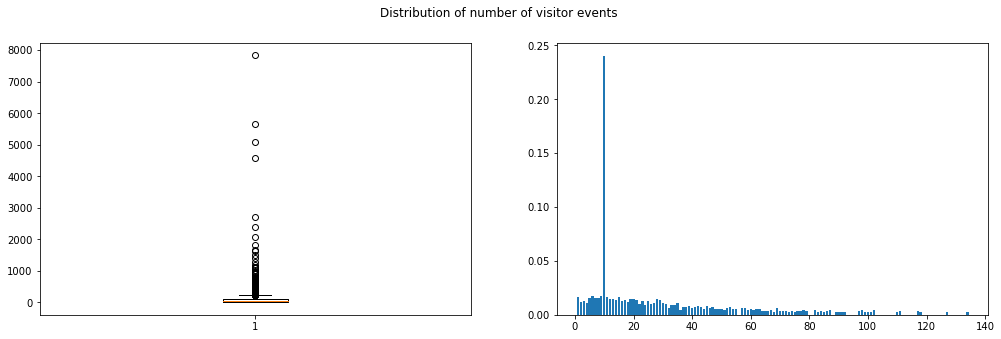

98.36% of visitors have more than 1 invoice!


In [361]:
# Distribution of number of visitor events
data1 = df.CustomerID.value_counts()  # count of orders per customerid
data2 = data1.value_counts(normalize=True)[:100]
data2[10] = data1.value_counts(normalize=True)[100:].sum()  # count of counts of orders per customerid

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
ax1.boxplot(data1)
ax2.bar(data2.index, data2.values)

#ax2.set_xticks(list(range(1,11)))
#ax2.set_xticklabels(list(range(1,10)) +['10+'])
fig.suptitle("Distribution of number of visitor events")

plt.show()
print("{0:.2f}% of visitors have more than 1 invoice!".format(100 * (np.sum(data1 > 1) / data1.shape[0])))

In [362]:
df.CustomerID.value_counts()

17841.0    7838
14911.0    5675
14096.0    5095
12748.0    4580
14606.0    2697
           ... 
17925.0       1
15118.0       1
16078.0       1
16073.0       1
17291.0       1
Name: CustomerID, Length: 4332, dtype: int64

<AxesSubplot:ylabel='Count'>

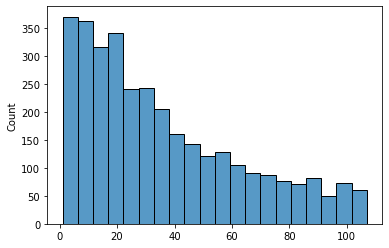

In [363]:
sns.histplot(df.groupby('CustomerID').count().InvoiceNo.sort_values().values[:3333])

<AxesSubplot:ylabel='Count'>

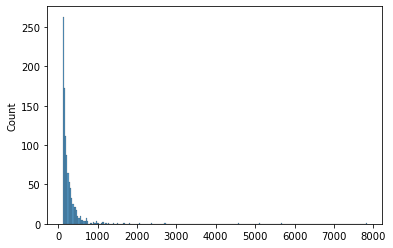

In [364]:
sns.histplot(df.groupby('CustomerID').count().InvoiceNo.sort_values().values[-1000:])

In [365]:
datetime_object = datetime.strptime('Jun 1 2005  1:33PM', '%b %d %Y %I:%M%p')

In [366]:
datetime.strptime(df.InvoiceDate, '%d/%b/%Y %I:%M')

TypeError: strptime() argument 1 must be str, not Series

In [367]:
df_date = df.InvoiceDate.str.split(expand=True)
df_date.head()

,0,1
0,12/1/2010,8:26
1,12/1/2010,8:26
2,12/1/2010,8:26
3,12/1/2010,8:26
4,12/1/2010,8:26


In [368]:
df_date.iloc[:,0]

0         12/1/2010
1         12/1/2010
2         12/1/2010
3         12/1/2010
4         12/1/2010
            ...    
541904    12/9/2011
541905    12/9/2011
541906    12/9/2011
541907    12/9/2011
541908    12/9/2011
Name: 0, Length: 528419, dtype: object

In [370]:
df.drop('InvoiceDate', axis=1, inplace=True)

In [372]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,FullDate
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01 08:26:00
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01 08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01 08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01 08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01 08:26:00


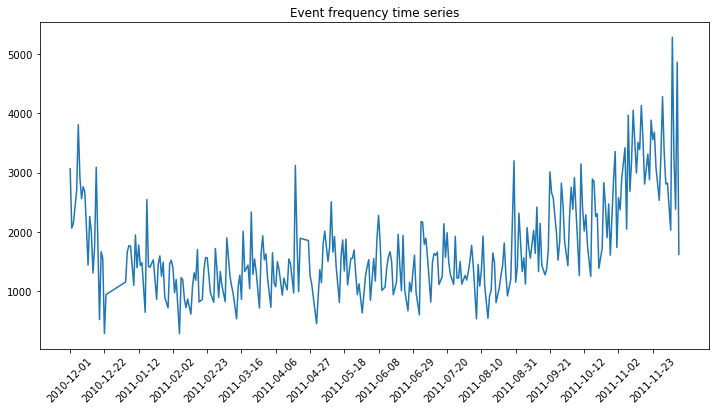

In [373]:
# Visualize number of events per day
data = pd.DatetimeIndex(df['FullDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(12,6))
plt.plot(data.index, data.values, linestyle="-")
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(21, unit='d')), rotation=45)
plt.title('Event frequency time series')
plt.show()

In [374]:
# How many weeks does the dataset has?
diff = (data.index.max() - data.index.min())
print(f"The dataset has {diff.days} days, corresponding to {diff.days//7} weeks.")

The dataset has 373 days, corresponding to 53 weeks.


### Model Implementation

In [375]:
def threshold_ratings(df, uid_min, iid_min, max_iter=None):
    """Removes users and items with less than uid_min and iid_min event occurrences, respectively.
    Credits: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
    """
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Raw dataset info \n-----------------')
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    
    done, i = False, 0
    while not done:
        # When we exclude users with freq less than uid_min we might end up with new 
        # items with freq less than iid_min, so we will have to alternate back and forth
        starting_shape = df.shape[0]  # number of existing events

        uid_counts = df.groupby('CustomerID').size()  # user id frequencies
        df = df[~df['CustomerID'].isin(uid_counts[uid_counts < uid_min].index.tolist())]  # keep events with users with frequency >= uid_min

        iid_counts = df.groupby('StockCode').size()  # item id frequencies
        df = df[~df['StockCode'].isin(iid_counts[iid_counts < iid_min].index.tolist())]  # keep events with items with frequency >= iid_min

        ending_shape = df.shape[0]  # number of existing events after filters
        i += 1
        if starting_shape == ending_shape or i == max_iter:  # convergence happens
            done = True
    
    if not max_iter:
        assert(df.groupby('CustomerID').size().min() >= uid_min)
        assert(df.groupby('StockCode').size().min() >= iid_min)
    
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Limited dataset info \n-----------------')
    print('Number of iterations until convergence: {}'.format(i))
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df

In [376]:
# get limited dataset
df_limited = threshold_ratings(df, 10, 10)

Raw dataset info 
-----------------
Number of users: 4332
Number of items: 3913
Sparsity: 3.117%
Limited dataset info 
-----------------
Number of iterations until convergence: 3
Number of users: 3749
Number of items: 3186
Sparsity: 4.374%


In [378]:
df_limited.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,FullDate
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01 08:26:00
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01 08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01 08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01 08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01 08:26:00


In [379]:
# Train-test split
start_train = df_limited['FullDate'].min()
start_test = start_train + pd.to_timedelta(15, unit='w')
end_test = start_test + pd.to_timedelta(5, unit='w')

# Create new limited df
df_limited = df_limited.loc[(df_limited['FullDate'] > start_train) & (df_limited['FullDate'] <= end_test)]

# Create train_split flag
df_limited['train_split'] = (df_limited['FullDate'] <= start_test).astype(int)
print("Proportion of train events: {:.2f}".format(df_limited['train_split'].mean()))

Proportion of train events: 0.73


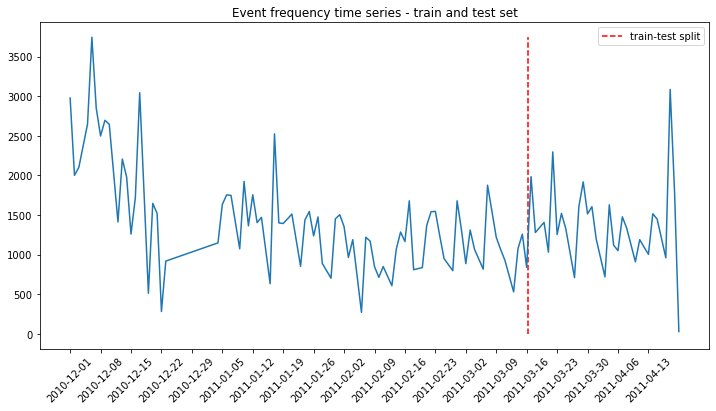

In [380]:
# Visualize train and test set
data = pd.DatetimeIndex(df_limited['FullDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(12,6))
plt.plot(data.index, data.values, linestyle="-")
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(7, unit='d')), rotation=45)
plt.vlines(start_test, 0, data.max(), linestyles='dashed', color='r', label='train-test split')
plt.legend()
plt.title('Event frequency time series - train and test set')
plt.show()

In [381]:
df_limited.train_split.describe()

count    157705.000000
mean          0.734828
std           0.441426
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: train_split, dtype: float64

In [382]:
df_limited.reset_index(inplace=True)

In [383]:
df_limited.head()

,index,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,FullDate,train_split
0,7,536366,22633,HAND WARMER UNION JACK,6,1.85,17850.0,United Kingdom,2010-12-01 08:28:00,1
1,8,536366,22632,HAND WARMER RED POLKA DOT,6,1.85,17850.0,United Kingdom,2010-12-01 08:28:00,1
2,9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,1.69,13047.0,United Kingdom,2010-12-01 08:34:00,1
3,10,536367,22745,POPPY'S PLAYHOUSE BEDROOM,6,2.10,13047.0,United Kingdom,2010-12-01 08:34:00,1
4,11,536367,22748,POPPY'S PLAYHOUSE KITCHEN,6,2.10,13047.0,United Kingdom,2010-12-01 08:34:00,1


In [384]:
df_limited.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157705 entries, 0 to 157704
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   index        157705 non-null  int64         
 1   InvoiceNo    157705 non-null  object        
 2   StockCode    157705 non-null  object        
 3   Description  157705 non-null  object        
 4   Quantity     157705 non-null  int64         
 5   UnitPrice    157705 non-null  float64       
 6   CustomerID   109185 non-null  float64       
 7   Country      157705 non-null  object        
 8   FullDate     157705 non-null  datetime64[ns]
 9   train_split  157705 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(4)
memory usage: 11.4+ MB


## Progress must be done from here onwards... 

In [385]:
# Dropping NaNs - the large number of null values in CustomerID and StockCode was preventing the algorithm to run
df_limited.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

In [386]:
df_limited

,index,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,FullDate,train_split
0,7,536366,22633,HAND WARMER UNION JACK,6,1.85,17850.0,United Kingdom,2010-12-01 08:28:00,1
1,8,536366,22632,HAND WARMER RED POLKA DOT,6,1.85,17850.0,United Kingdom,2010-12-01 08:28:00,1
2,9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,1.69,13047.0,United Kingdom,2010-12-01 08:34:00,1
3,10,536367,22745,POPPY'S PLAYHOUSE BEDROOM,6,2.10,13047.0,United Kingdom,2010-12-01 08:34:00,1
4,11,536367,22748,POPPY'S PLAYHOUSE KITCHEN,6,2.10,13047.0,United Kingdom,2010-12-01 08:34:00,1
...,...,...,...,...,...,...,...,...,...,...
157700,164664,550656,23075,PARLOUR CERAMIC WALL HOOK,4,4.15,17652.0,United Kingdom,2011-04-20 08:07:00,0
157701,164665,550657,22178,VICTORIAN GLASS HANGING T-LIGHT,192,1.06,18198.0,United Kingdom,2011-04-20 08:24:00,0
157702,164666,550657,21313,GLASS HEART T-LIGHT HOLDER,96,0.64,18198.0,United Kingdom,2011-04-20 08:24:00,0
157703,164667,550657,22457,NATURAL SLATE HEART CHALKBOARD,6,2.95,18198.0,United Kingdom,2011-04-20 08:24:00,0


We need to sparse these strings in order to susbtitute letters from some codes into numbers, make the column all integer and run the next cell again. This may solve next cell's issue with negative indexes. We think this will solve the problem of the next cell which states that we have negative index on df_limited. 

Sources for solving this issue to remove letter from StockCode column:
https://stackoverflow.com/questions/15558392/how-can-i-check-if-character-in-a-string-is-a-letter-python 
(isalpha() method for any letter in the alphabet)
https://www.geeksforgeeks.org/python-pandas-series-str-find/ (find() method to search for a certain letter)

In [387]:
df_limited['StockCode'].value_counts()

85123A    771
22423     635
22720     479
85099B    426
84879     423
         ... 
90125B      1
90099       1
15030       1
90214V      1
85131D      1
Name: StockCode, Length: 2556, dtype: int64

The Categoricals data structure consists of a categories array and an integer array of codes which point to the real value in the categories array

In [388]:
user_cat = df_limited['CustomerID'].astype("category")
item_cat = df_limited['StockCode'].astype("category")

In [389]:
user_cat.cat.codes.sort_values()

14332        0
14348        0
142039       0
142040       0
69336        0
          ... 
99576     2121
99575     2121
99574     2121
99572     2121
65402     2121
Length: 109185, dtype: int16

In [390]:
coo_matrix((df_limited['train_split'],
                              (item_cat.cat.codes,
                               user_cat.cat.codes))).tocsr()

<2556x2122 sparse matrix of type '<class 'numpy.intc'>'
	with 88163 stored elements in Compressed Sparse Row format>

Create a sparse matrix of all the item/user/counts triples for the train set and test set

In [391]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy.sparse.coo_matrix
item_user_train = coo_matrix((df_limited['train_split'],
                              (item_cat.cat.codes,
                               user_cat.cat.codes))).tocsr()
item_user_train.eliminate_zeros()  # remove zero entries

In [392]:
# produce transpose of item_user_train
user_item_train = item_user_train.T

item_user_test = coo_matrix(((~df_limited['train_split'].astype(bool)).astype(int),
                             (item_cat.cat.codes,
                              user_cat.cat.codes))).tocsr()
item_user_test.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_test
user_item_test = item_user_test.T

# map each item and user category to a unique numeric code
user_map = dict(zip(user_cat, user_cat.cat.codes))
item_map = dict(zip(item_cat, item_cat.cat.codes))

def get_keys(value, dictionary):
    """Function to get dictionary keys with specifiec value"""
    return list(dictionary.keys())[list(dictionary.values()).index(value)]

# confirm shapes
print(f"train set shape: {item_user_train.shape} and test set shape: {item_user_test.shape}")

# check sparsity
pzeros_train = 100 * (1 - item_user_train.count_nonzero() / (item_user_train.shape[0] * item_user_train.shape[1]))
pzeros_test = 100 * (1 - item_user_test.count_nonzero() / (item_user_test.shape[0] * item_user_test.shape[1]))
print(f"train set percentage of zeros: {pzeros_train} and test set percentage of zeros: {pzeros_test}")

train set shape: (2556, 2122) and test set shape: (2556, 2122)
train set percentage of zeros: 98.80735612754967 and test set percentage of zeros: 99.45634378055958


In [393]:
# users with no items on the train set and not items on the test set
zero_users_test = (np.squeeze(np.asarray(user_item_test.sum(axis=1))) == 0).nonzero()[0]
zero_users_train = (np.squeeze(np.asarray(user_item_train.sum(axis=1))) == 0).nonzero()[0]
set(zero_users_test).intersection(zero_users_train)

set()

In [394]:
# most frequent user, item pair in train set
item_id, user_id = np.unravel_index(item_user_train.argmax(), item_user_train.shape)
item_id, user_id = get_keys(item_id, item_map), get_keys(user_id, user_map)
df_limited.loc[(df_limited['CustomerID'] == user_id) & (df_limited['StockCode'] == item_id) & (df_limited['train_split'] == 1)]

,index,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,FullDate,train_split
2003,2095,536557,79321,CHILLI LIGHTS,24,4.25,17841.0,United Kingdom,2010-12-01 14:41:00,1
6700,6995,536984,79321,CHILLI LIGHTS,24,4.25,17841.0,United Kingdom,2010-12-03 14:35:00,1
12444,12963,537405,79321,CHILLI LIGHTS,30,4.25,17841.0,United Kingdom,2010-12-06 14:51:00,1
29109,30437,538866,79321,CHILLI LIGHTS,24,4.25,17841.0,United Kingdom,2010-12-14 14:40:00,1
35931,37526,539469,79321,CHILLI LIGHTS,24,4.25,17841.0,United Kingdom,2010-12-19 13:59:00,1
40936,42796,540021,79321,CHILLI LIGHTS,48,4.25,17841.0,United Kingdom,2011-01-04 12:51:00,1
47747,49899,540538,79321,CHILLI LIGHTS,34,4.25,17841.0,United Kingdom,2011-01-09 14:36:00,1
52047,54377,540943,79321,CHILLI LIGHTS,3,4.95,17841.0,United Kingdom,2011-01-12 12:31:00,1
56131,58579,541253,79321,CHILLI LIGHTS,30,4.25,17841.0,United Kingdom,2011-01-16 13:51:00,1
61077,63631,541587,79321,CHILLI LIGHTS,24,4.25,17841.0,United Kingdom,2011-01-19 14:39:00,1


### ALS Model
Alternating Least Squares (ALS) is a the model we'll use to fit our data and find similarities. But before we dive into how it works we should look at some of the basics of matrix factorization which is what we aim to use ALS to accomplish.

In [395]:
# initialize a model
alpha = 40  # as we observe more evidence for positive preference, our confidence in pui = 1 increases according to alpha (rate of increase)
als_model = AlternatingLeastSquares(factors=200, regularization=0.01, iterations=30, random_state=0)

# train the model on a sparse matrix of item/user/confidence weights
# os.environ['MKL_NUM_THREADS'] = '1'
# os.environ['OPENBLAS_NUM_THREADS'] = '1'
# about the alpha hyperparameter: https://github.com/benfred/implicit/issues/199#issuecomment-490350326
als_model.fit((item_user_train * alpha).astype('double'))

In [396]:
# recommend items for a user. 
# the recommended items have the largest inner product with the user vector
user_id = list(user_map.keys())[0]
recommendations = als_model.recommend(user_map[user_id], user_item_train)
list(map(lambda x: (get_keys(x[0], item_map), x[1]), recommendations))

[('82482', 1.0047301),
 ('84029E', 1.0011277),
 ('82486', 1.0009933),
 ('82483', 1.000782),
 ('82494L', 1.0004047),
 ('21068', 1.0003929),
 ('22411', 1.0003719),
 ('22752', 1.0002913),
 ('85123A', 1.0000988),
 ('82484', 1.0000947)]

In [397]:
# find related items
# the related items have the largest inner product with the item vector
item_id = list(item_map.keys())[0]
related = als_model.similar_items(item_map[item_id])
list(map(lambda x: (get_keys(x[0], item_map), x[1]), related))

[('22633', 1.0),
 ('22866', 0.72055763),
 ('22632', 0.65961766),
 ('22865', 0.6221769),
 ('22867', 0.60115767),
 ('21306', 0.50181115),
 ('82616B', 0.50172657),
 ('22182', 0.5003459),
 ('90199C', 0.49917564),
 ('90129F', 0.4979859)]

In [398]:
# show the top 10 items that explain the recommended item to the user
# It is possible to write the LVM as a linear function between preferences and past actions.
# We can then see what are the actions associated with the highest contributions to the given recommendation.
score, contributions, user_weights = als_model.explain(user_map[user_id], 
                                                       user_item_train,
                                                       item_map[item_id])
print("The score of the user/item pair is: ", score)
print("The top N (itemid, score) contributions for this user/item pair are:\n", list(map(lambda x: (get_keys(x[0], item_map), x[1]), contributions)))

The score of the user/item pair is:  0.8795798189344682
The top N (itemid, score) contributions for this user/item pair are:
 [('22633', 0.6556118007703339), ('22632', 0.155846860790013), ('84406B', 0.024097039161292085), ('82494L', 0.023580143371430894), ('85123A', 0.02294703456017823), ('21730', 0.015600877083994436), ('84029G', 0.009253853905779187), ('21068', 0.007412478305994294), ('84029E', 0.005411043805687627), ('22752', 0.004581873806100985)]


In [399]:
# Baseline: Recommend the most popular items to every user
class PopularRecommender():
    """Baseline Recommender that always suggests the most popular items to every user.
    """
    def fit(self, item_users):
        self.item_id_sort = np.argsort(np.squeeze(np.asarray(item_users.sum(axis=1).reshape(-1))))[::-1]
    
    def recommend(self, userid, user_items, N=10, filter_already_liked_items=None, filter_items=None, recalculate_user=None):
        if filter_already_liked_items != None or filter_items != None or recalculate_user != None:
            raise NotImplementedError("filter_already_liked_items, filter_items and recalculate_user aren't support yet")
        
        return list(zip(self.item_id_sort[:N], range(1, N + 1)))

In [400]:
# Fitting PopularRecommender model
pop_model = PopularRecommender()
pop_model.fit(item_user_train)

In [413]:
from implicit.bpr import BayesianPersonalizedRanking

# Fitting BayesianPersonalizedRanking model
bayes_model = BayesianPersonalizedRanking()
bayes_model.fit(item_user_train)

In [414]:
from implicit.lmf import LogisticMatrixFactorization

# Fitting LogisticMatrixFactorization model
log_model = LogisticMatrixFactorization()
log_model.fit(item_user_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.05it/s]


In [415]:
# Evaluate models. 
# Precision at K, Mean Average Precision at K, Normalized Discounted Cumulative Gain at K, AUC at K
eval_models = {'pop_model': pop_model, 
               'als_model': als_model, 
               'bayes_model': bayes_model,
              'log_model':log_model}
eval_table = {}
for k, v in eval_models.items():
    eval_table[k] = ranking_metrics_at_k(v, user_item_train, user_item_test, K=10, show_progress=True, num_threads=0)
eval_table = pd.DataFrame(eval_table)
eval_table

,pop_model,als_model,bayes_model,log_model
precision,0.099680,0.049015,0.057682,0.089361
map,0.049113,0.020124,0.021745,0.038025
ndcg,0.112403,0.050547,0.055736,0.089364
auc,0.521571,0.508786,0.510599,0.517492
